In [ ]:
import sys
sys.path.insert(0, '../Utilities')

import numpy as np
from itertools import combinations
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx
from networkx.algorithms import bipartite

import hypergraphx as hx
from hypergraphx.core.hypergraph import Hypergraph
from hypergraphx.representations.projections import bipartite_projection

from utilities_fibration import *
from trajectories_kuramoto_hoi import *
from find_sync_clusters_from_trajectories import *


import matplotlib as mpl
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # use serif font
    "text.latex.preamble": r"\usepackage{lmodern}",  # match LaTeX document font
})


In [4]:
# Define hypergraph
edge_list_sc_filtered_hpg = [[0,1,2],[0,6],[6,3],[3,4],[4,5],[5,3], [6,7],[7,8,9],[8,9]] 

# Skeleton graph from hypergraph
edge_list_sc_filtered = [
    list(c)
    for f in edge_list_sc_filtered_hpg
    for c in combinations(f, 2)
]

In [5]:
# Transform edge list into a multigraph
g_test = nx.MultiGraph(edge_list_sc_filtered)

In [6]:
# Compute fibration coloring on the multigraph
result_graph_g_test = kameicock_coloring_multi(g_test, {})#, initial_types)
result_graph_g_test

{0: 3, 1: 1, 2: 1, 6: 0, 3: 3, 4: 1, 5: 1, 7: 4, 8: 2, 9: 2}

In [7]:
# extract colors only of node in layer 0
nodes_coloring_gr_test = {n: c for n, c in result_graph_g_test.items()}
# Set of clusters
cl_gr_test = []

for val in set(nodes_coloring_gr_test.values()):
    cl_gr_test.append([k for k, v in nodes_coloring_gr_test.items() if v == val])

# Ratio nodes/cluster
print(len(g_test.nodes()))
len(g_test.nodes())/len(cl_gr_test)

10


2.0

In [8]:
# Partitions of the nodes in fibres
cl_gr_test

[[6], [1, 2, 4, 5], [8, 9], [0, 3], [7]]

In [9]:
# Compute trajectories on the multigraph for the Kuramoto model with frustration parameters
# Fix initial conditions

multi_g = edge_list_sc_filtered

# Number of nodes
N = len(g_test.nodes())

# Natural frequencies
omega = np.zeros(N)

# Initial conditions
IC = np.ones(N)

# Coupling strengths
sigma2 = 0.2
sigma3 = 0.8

In [10]:
# Integration times and steps
T_max = 1000
step = 1
repetition = T_max/step

In [11]:
#  Simulate
model = KuramotoHypergraph(multi_g, omega, [sigma2,sigma3], [np.pi/6, np.pi/3])
times, theta_history = model.simulate(T=repetition, dt=step, initial_conditions=IC)

In [12]:
clusters = cl_gr_test 
# Add a fake cluster with all the nodes to check that they are synchronized only in the graph fibres
clusters_examin = clusters + [[1,2,4,5,8,9]]

In [13]:
# Compute max diff in each cluster
cluster_states = []
for cluster in clusters_examin:
    arrays = theta_history[:,[i for i in cluster]]
    min_vals = np.min(arrays, axis=1) 
    max_vals = np.max(arrays, axis=1) 
    cluster_states.append(abs(max_vals - min_vals))
cluster_states = np.array(cluster_states) 

In [14]:
# CLusters with more than one nodes
c = [e for e in clusters_examin if len(e) > 1]
num_nontrivial_clusters = len(c)
print(f'Number of non trivial clusters: {num_nontrivial_clusters}')
c

Number of non trivial clusters: 4


[[1, 2, 4, 5], [8, 9], [0, 3], [1, 2, 4, 5, 8, 9]]

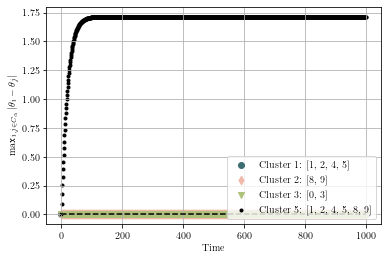

In [15]:

markers = ['o', "d","v",'.', '.']
cluster_colors = [
'#3c6e71',#c1
'#efb8a9',#c7
'#adc178',#c6
'black',
'blue'
]

plt.figsize=(15, 30)

# Plot the synchronization error

i = 0
for cluster_i, max_diff in enumerate(cluster_states):
    if len(clusters_examin[cluster_i]) > 1:
        plt.scatter(times, max_diff, marker=markers[i%5], color=cluster_colors[i%5], label=f'Cluster {cluster_i}: {clusters_examin[cluster_i]}')

        plt.hlines(y = 0, xmin = times[0], xmax = times[-1], color=cluster_colors[i], linestyle = '--')
        i += 1

plt.xlabel('Time')
label = r'$\max_{i,j \in C_\alpha} \vert \theta_i - \theta_j \vert$'
plt.ylabel(label)
if num_nontrivial_clusters < 15:
    plt.legend(loc='lower right', ncol=1)
plt.tick_params(axis='both', which='major')
#plt.title(f'Maximim phase difference intra-cluster I.C. $\sigma_2 = {sigma2}, \sigma_3 = {sigma3}$')
plt.grid()

Global parameter: 0.7830705197286646
Cluster [1, 2, 4, 5]: 1.0
Cluster [8, 9]: 1.0
Cluster [0, 3]: 1.0
Cluster [1, 2, 4, 5, 8, 9]: 0.7094181483548291


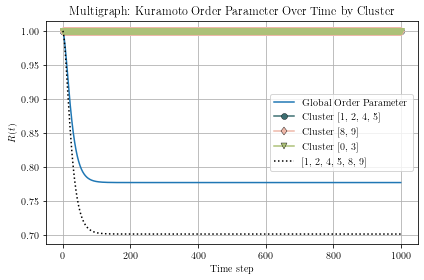

In [16]:
# Plot the Kuramoto order parameter over time for each cluster and global

plt.figure(figsize=(6, 4))


arrays = theta_history[:,]
R_tot = kuramoto_order_parameter_over_time(arrays)
plt.plot(R_tot, label='Global Order Parameter', linestyle = '-')
print(f'Global parameter: {np.sum(R_tot) / repetition}')

for i,cluster in enumerate(c):
    arrays = theta_history[:,[i for i in cluster]]
    R = kuramoto_order_parameter_over_time(arrays)
    print(f'Cluster {cluster}: {np.sum(R) / repetition}')

    if cluster !=  [1,2,4,5,8,9]:
        plt.plot(R, marker=markers[i%5], color=cluster_colors[i%5], label=f'Cluster {cluster}')
    
    else:
        plt.plot(R, color=cluster_colors[i%5], label=f'{cluster}', linestyle = ':')



plt.xlabel('Time step')
plt.ylabel('$R(t)$')
plt.title(f'Multigraph: Kuramoto Order Parameter Over Time by Cluster')
plt.grid(True)
if num_nontrivial_clusters < 15: # Avoid overcrowded legends
    leg = plt.legend(loc='best', framealpha=0.8)

    for h in leg.legendHandles:                   
        h.set_markeredgecolor('black') 
        h.set_markeredgewidth(0.4) 
plt.tight_layout()

#plt.savefig(f'Images/Frustration_results/Order_parameters_time_example_comparison_multigraph', dpi=1000, bbox_inches=None, transparent=True)


***Detection of the fibres starting from the dynamic.***
 
To apply the algorithm, I write for each node the sequence containing the number of edges to which it belongs having increasing cardinality.
Then I categorize the nodes having the same degree sequence.

In [17]:
H = Hypergraph(edge_list_sc_filtered)

rk = 2 # it is a multigraph

# Assign to each node its degree sequence
nodes_deg_seq = {n: [H.degree(n, order = ord) for ord in range(1,rk+1)] for n in H.get_nodes()}
nodes_deg_seq

print(nodes_deg_seq)

# Group nodes by degree
degree_seq_to_nodes = defaultdict(list)
for node, degrees in nodes_deg_seq.items():
    degree_seq_to_nodes[tuple(degrees)].append(node)
    
dict_nodes = dict(degree_seq_to_nodes)
print(dict_nodes)    

{0: [3, 0], 1: [2, 0], 2: [2, 0], 6: [3, 0], 3: [3, 0], 4: [2, 0], 5: [2, 0], 7: [3, 0], 8: [2, 0], 9: [2, 0]}
{(3, 0): [0, 6, 3, 7], (2, 0): [1, 2, 4, 5, 8, 9]}


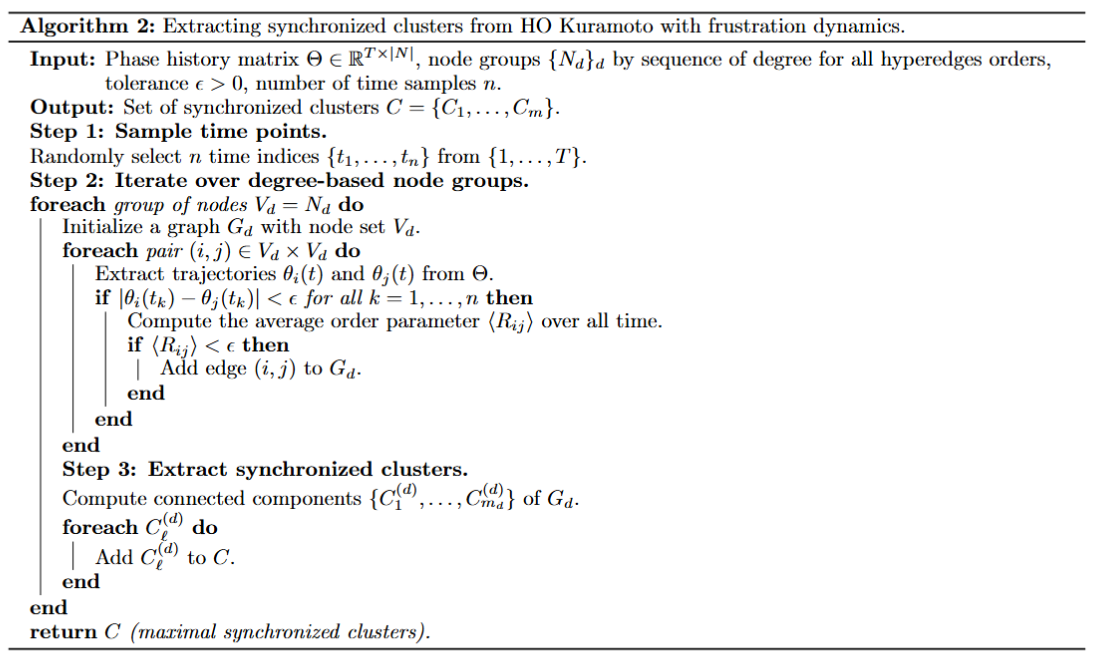

In [18]:
# Apply the function that, given the trajectories and the nodes grouped by degree, finds the non trivial synchronized clusters (In the paper is Algorithm 2)

synchronized_clusters = find_synchronized_clusters_from_pairs(
    theta_history=theta_history,
    nodes_by_degree=dict_nodes,
    tol=1e-6,
    phase_tol=0.05,
    n_check_times=5
)
print(synchronized_clusters)

  0%|          | 0/2 [00:00<?, ?it/s]

Degree sequence: (3, 0) (4 nodes)


100%|██████████| 2/2 [00:01<00:00,  1.67it/s]

Degree sequence: (2, 0) (6 nodes)
[[0, 3], [1, 2, 4, 5], [8, 9]]


In [19]:
# Check if the synchronized clusters found correspond to the fibration clusters for nontrivial clusters

set1 = set(frozenset(inner) for inner in [e for e in clusters if len(e) > 1])
set2 = set(frozenset(inner) for inner in synchronized_clusters)


print([e for e in clusters if len(e) > 1])
print(synchronized_clusters)
print(set2 == set1)
set1.symmetric_difference(set2)

[[1, 2, 4, 5], [8, 9], [0, 3]]
[[0, 3], [1, 2, 4, 5], [8, 9]]
True


set()

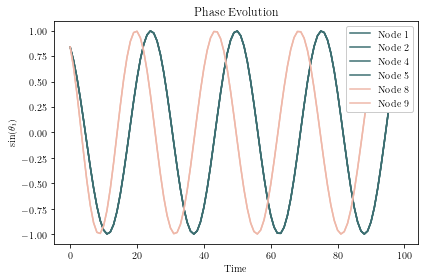

In [20]:
# Plot trajectories results

plt.figure(figsize=(6, 4))

# Markers and colors as in the tikz picture of the paper
markers = ['o', '*', "v", "^", "d", "s", "p"]
colors = [
'#3c6e71',#c1
'#3c6e71',#c1
'#3c6e71',#c1
'#3c6e71',#c1
'#efb8a9',#c7
'#efb8a9',#c7
'#bc4749',#c5
'#bc4749',#c5
'#a8dadc',#c2
'#e9c46a',#c3
'#a3a6c2',#c4
'#adc178',#c6
]

# Plot only trajectories of chosen nodes, that synchronize only in the graph fibres

for idx, i in enumerate([1,2,4,5,8,9]):
    plt.plot(times[0:100], np.sin(theta_history[0:100,i]), label=f'Node {i}', color = colors[idx])
plt.xlabel('Time')
plt.ylabel(r'$\sin(\theta_i$)')
plt.title('Phase Evolution')
plt.legend(loc='upper right', framealpha=1)
plt.tight_layout()

#plt.savefig(f'Images/Frustration_results/Phase_evolution_time_example_comparison_multigraph', dpi=1000, bbox_inches=None, transparent=True)